# Case Study 3

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




Import Library 

In [1]:
import csv
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
import statsmodels.api as sm
from statsmodels.stats import outliers_influence
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn import metrics

Load Data

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

EDA

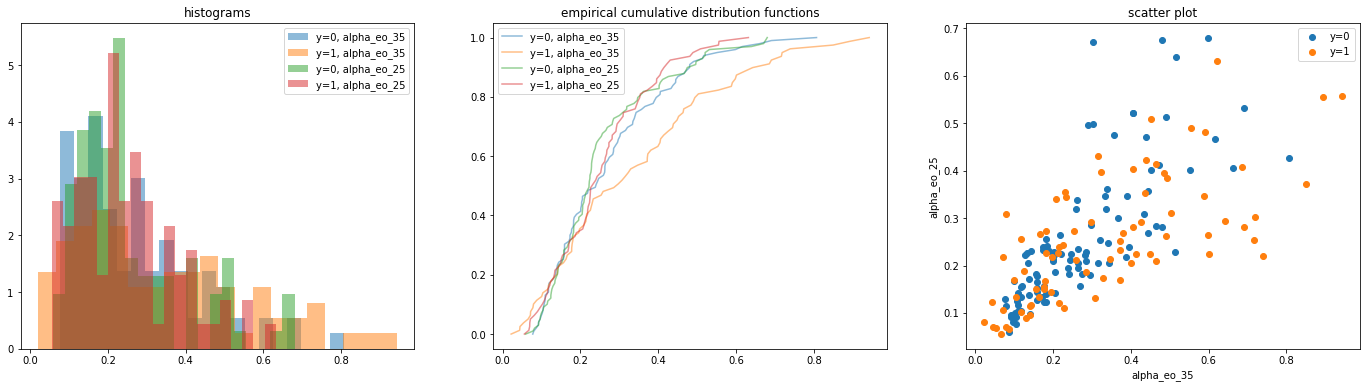

In [3]:

# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [4]:
# Data frame
df = pd.DataFrame(X)
df.columns = feature_names
target = pd.DataFrame({'label':y})
df1 = pd.concat([df, target], axis=1)

In [5]:
df.shape

(180, 432)

In [6]:
df.head()

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47
0,0.11184,0.12387,0.12858,0.11324,0.10571,0.10690,0.10756,0.11064,0.10875,0.15893,...,0.57161,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294,1.01440
1,0.29834,0.26881,0.26239,0.38009,0.34358,0.28500,0.24791,0.25033,0.26047,0.26016,...,0.35142,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658,0.74867
2,0.36912,0.39587,0.38999,0.25772,0.40554,0.44199,0.44004,0.39947,0.31546,0.28348,...,0.61924,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363,0.61417
3,0.76120,0.77726,0.77042,0.60161,0.70183,0.72725,0.76245,0.78904,0.72984,0.52236,...,0.23456,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250,0.85448
4,0.16770,0.15146,0.14714,0.15728,0.14965,0.14154,0.13228,0.12760,0.14351,0.17252,...,1.82160,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770,2.29460


In [7]:
bin_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
df['group'] = pd.qcut(df.index, q=18, labels=bin_labels)
df

,alpha_ec_0,alpha_ec_1,alpha_ec_2,alpha_ec_3,alpha_ec_4,alpha_ec_5,alpha_ec_6,alpha_ec_7,alpha_ec_8,alpha_ec_9,...,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47,group
0,0.111840,0.123870,0.128580,0.113240,0.105710,0.106900,0.107560,0.110640,0.108750,0.158930,...,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294,1.01440,1
1,0.298340,0.268810,0.262390,0.380090,0.343580,0.285000,0.247910,0.250330,0.260470,0.260160,...,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658,0.74867,1
2,0.369120,0.395870,0.389990,0.257720,0.405540,0.441990,0.440040,0.399470,0.315460,0.283480,...,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363,0.61417,1
3,0.761200,0.777260,0.770420,0.601610,0.701830,0.727250,0.762450,0.789040,0.729840,0.522360,...,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250,0.85448,1
4,0.167700,0.151460,0.147140,0.157280,0.149650,0.141540,0.132280,0.127600,0.143510,0.172520,...,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770,2.29460,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.079822,0.081258,0.079273,0.083723,0.069784,0.063498,0.061792,0.059784,0.066457,0.077352,...,1.16220,0.95190,2.32520,1.87490,1.74620,2.72400,2.71860,2.82880,1.23630,18
176,0.346500,0.362790,0.343660,0.277240,0.316030,0.379750,0.420140,0.452390,0.421380,0.250020,...,0.67680,0.82459,0.37865,0.45749,0.61751,0.35155,0.48109,0.65537,0.64262,18
177,0.159210,0.157820,0.169680,0.178980,0.140980,0.132490,0.126600,0.130490,0.149720,0.222240,...,0.85727,0.64390,0.87481,1.09470,0.99918,0.65529,0.63907,0.62307,1.07070,18
178,0.941110,0.952930,0.950500,0.726600,0.766260,0.655290,0.636660,0.645460,0.763470,0.841900,...,0.94833,0.59572,0.80736,0.71848,0.96166,0.98636,0.99212,0.97502,0.97734,18


Let's see the performance of model without doing Feature Engg.

In [11]:
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)','Specificity','Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['SVM']
scores_df = scores_df.set_index('Classifier')
acc_val = []
specific_val = []
sensitivity_val = []
logo = LeaveOneGroupOut()
svm_model = SVC()
# X = np.array(df)
for train_index, test_index in logo.split(X, y,np.array(df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  svm_model.fit(X_train,y_train)
  y_pred = svm_model.predict(X_test)
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['SVM'].iat[0] = acc_mean
scores_df.loc['SVM'].iat[1] = acc_std
scores_df.loc['SVM'].iat[2] = specific_val_mean
scores_df.loc['SVM'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to 

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
SVM,0.661111,0.11125,0.8,0.8


In [13]:
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)', 'Specificity','Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['KNN']
scores_df = scores_df.set_index('Classifier')
acc_val = []
specific_val = []
sensitivity_val = []
logo = LeaveOneGroupOut()
knn_model = KNeighborsClassifier()

for train_index, test_index in logo.split(X, y,np.array(df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  knn_model.fit(X_train,y_train)
  y_pred = knn_model.predict(X_test)
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['KNN'].iat[0] = acc_mean
scores_df.loc['KNN'].iat[1] = acc_std
scores_df.loc['KNN'].iat[2] = specific_val_mean
scores_df.loc['KNN'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to 

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
KNN,0.688889,0.13287,0.9,0.8


**Filter Method - Variance Threshold Method**

Step 1 : Removing Constant Feature

In [14]:
#Step 1
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(df)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in df.columns
                    if column not in df.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))

#Constant columns names:
for column in constant_columns:
    print(column)

(180, 433)
0


Step 2 : Removing Quasi-Constant Features

In [15]:
#Step 2: 

qcons_filter = VarianceThreshold(threshold=0.01)

#Fit and transforming on train data
data_qcons = qcons_filter.fit_transform(df)
print(data_qcons.shape)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in df.columns
                    if column not in df.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns))

#Quasi Constant columns names:
for column in qcons_columns:
    print(column)

(180, 287)
146
beta_ec_0
beta_ec_1
beta_ec_2
beta_ec_3
beta_ec_8
beta_ec_9
beta_ec_13
beta_ec_14
beta_ec_15
beta_ec_16
beta_ec_20
beta_ec_21
beta_ec_23
beta_ec_24
beta_ec_25
beta_ec_26
beta_ec_28
beta_ec_29
beta_ec_30
beta_ec_32
beta_ec_33
beta_ec_34
beta_ec_35
beta_ec_36
beta_ec_37
beta_ec_38
beta_ec_39
beta_ec_40
beta_ec_41
beta_ec_42
beta_ec_43
beta_ec_44
beta_ec_45
beta_ec_46
beta_ec_47
theta_ec_0
theta_ec_1
theta_ec_2
theta_ec_3
theta_ec_4
theta_ec_5
theta_ec_6
theta_ec_7
theta_ec_8
theta_ec_9
theta_ec_10
theta_ec_11
theta_ec_12
theta_ec_13
theta_ec_14
theta_ec_15
theta_ec_16
theta_ec_17
theta_ec_18
theta_ec_19
theta_ec_20
theta_ec_21
theta_ec_22
theta_ec_23
theta_ec_24
theta_ec_25
theta_ec_26
theta_ec_27
theta_ec_28
theta_ec_29
theta_ec_30
theta_ec_31
theta_ec_32
theta_ec_33
theta_ec_34
theta_ec_35
theta_ec_36
theta_ec_37
theta_ec_38
theta_ec_39
theta_ec_40
theta_ec_41
theta_ec_42
theta_ec_43
theta_ec_44
theta_ec_45
theta_ec_46
theta_ec_47
beta_eo_3
beta_eo_9
beta_eo_15
beta_eo_1

In [16]:
#Dropping Quasi Constant
data_qcons = df.drop(qcons_columns,axis=1)
data_qcons.shape
new_df = data_qcons

Step 3: Removing Duplicate Columns

In [17]:
data_qcons_t = data_qcons.T
data_qcons_t.shape

(287, 180)

In [18]:
print(data_qcons_t.duplicated().sum())

0


There is no Duplicate column. 
Next step. Step: 4 Correlation of Features with the Target Variable

In [19]:
corrmat = df1.corr()
corr_var=corrmat['label'].sort_values(ascending=False).head(10).to_frame()

corr_var


,label
label,1.000000
ratio_beta_34,0.470168
ratio_beta_35,0.429376
ratio_beta_37,0.424019
ratio_beta_4,0.420971
ratio_beta_2,0.384749
ratio_beta_0,0.383688
ratio_beta_29,0.374045
ratio_beta_47,0.367900
ratio_beta_21,0.359202


In [20]:
corr_var['feature'] = corr_var.index
corr_var.reset_index()
corr_var

,label,feature
label,1.000000,label
ratio_beta_34,0.470168,ratio_beta_34
ratio_beta_35,0.429376,ratio_beta_35
ratio_beta_37,0.424019,ratio_beta_37
ratio_beta_4,0.420971,ratio_beta_4
ratio_beta_2,0.384749,ratio_beta_2
ratio_beta_0,0.383688,ratio_beta_0
ratio_beta_29,0.374045,ratio_beta_29
ratio_beta_47,0.367900,ratio_beta_47
ratio_beta_21,0.359202,ratio_beta_21


In [21]:
#setting thereshold 0.4
cor_arr = []
for i, values in corr_var.iterrows():
  if values['label']> 0.4:
    cor_arr.append(values['feature'])
cor_arr.pop(0)
cor_arr

['ratio_beta_34', 'ratio_beta_35', 'ratio_beta_37', 'ratio_beta_4']

In [22]:
#Dropping the above column from df as they are highly correlated
new_df =new_df.drop(cor_arr, axis = 1)
new_df.shape

(180, 283)

Step 5 : Correlation Among Independent Variable

In [23]:
cor_matrix = new_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
len(to_drop)

<ipython-input-23-05529cf09fab>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


48

In [24]:
#Dropping the above column from df as they are highly correlated
new_df = new_df.drop(to_drop, axis = 1)
new_df

,alpha_ec_0,alpha_ec_3,alpha_ec_4,alpha_ec_9,alpha_ec_14,alpha_ec_16,alpha_ec_17,alpha_ec_18,alpha_ec_19,alpha_ec_20,...,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46,ratio_theta_47,group
0,0.111840,0.113240,0.105710,0.158930,0.104710,0.081195,0.10175,0.096976,0.080601,0.074637,...,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294,1.01440,1
1,0.298340,0.380090,0.343580,0.260160,0.241930,0.202560,0.33360,0.359700,0.367900,0.357870,...,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658,0.74867,1
2,0.369120,0.257720,0.405540,0.283480,0.314970,0.334010,0.41165,0.435750,0.314660,0.312100,...,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363,0.61417,1
3,0.761200,0.601610,0.701830,0.522360,0.671610,0.506580,0.42615,0.399880,0.402960,0.435990,...,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250,0.85448,1
4,0.167700,0.157280,0.149650,0.172520,0.214400,0.166990,0.13692,0.157780,0.231620,0.255770,...,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770,2.29460,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.079822,0.083723,0.069784,0.077352,0.062281,0.088269,0.06100,0.079128,0.141140,0.118070,...,1.16220,0.95190,2.32520,1.87490,1.74620,2.72400,2.71860,2.82880,1.23630,18
176,0.346500,0.277240,0.316030,0.250020,0.565130,0.292720,0.35489,0.389850,0.465300,0.508410,...,0.67680,0.82459,0.37865,0.45749,0.61751,0.35155,0.48109,0.65537,0.64262,18
177,0.159210,0.178980,0.140980,0.222240,0.206320,0.182890,0.23536,0.288640,0.172490,0.168000,...,0.85727,0.64390,0.87481,1.09470,0.99918,0.65529,0.63907,0.62307,1.07070,18
178,0.941110,0.726600,0.766260,0.841900,0.544180,0.424990,0.39758,0.432980,0.430490,0.510200,...,0.94833,0.59572,0.80736,0.71848,0.96166,0.98636,0.99212,0.97502,0.97734,18


Score using Filter Method

In [25]:
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)', 'Specificity', 'Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['SVM']
scores_df = scores_df.set_index('Classifier')
acc_val = []
specific_val = []
sensitivity_val = []
logo = LeaveOneGroupOut()
svm_model = SVC()
X = np.array(new_df)
for train_index, test_index in logo.split(X, y,np.array(new_df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  svm_model.fit(X_train,y_train)
  y_pred = svm_model.predict(X_test)
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['SVM'].iat[0] = acc_mean
scores_df.loc['SVM'].iat[1] = acc_std
scores_df.loc['SVM'].iat[2] = specific_val_mean
scores_df.loc['SVM'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being se

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
SVM,0.988889,0.031427,1.0,1.0


In [27]:
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)', 'Specificity', 'Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['KNN']
scores_df = scores_df.set_index('Classifier')
acc_val = []
specific_val = []
sensitivity_val = []
logo = LeaveOneGroupOut()
knn_model = KNeighborsClassifier()
X = np.array(new_df)

for train_index, test_index in logo.split(X, y,np.array(new_df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  knn_model.fit(X_train,y_train)
  y_pred = knn_model.predict(X_test)
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['KNN'].iat[0] = acc_mean
scores_df.loc['KNN'].iat[1] = acc_std
scores_df.loc['KNN'].iat[2] = specific_val_mean
scores_df.loc['KNN'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being se

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
KNN,0.938889,0.11125,1.0,1.0


**Wrapper Method**

**Forward Method**

In [28]:
#Forward Method
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features
    
feature = forward_selection(df, target)
forward_df = df.filter(feature, axis=1)
print(forward_df)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/ts

    group  ratio_beta_0  ratio_beta_45  theta_eo_26  alpha_ec_25  alpha_ec_40  \
0       1       1.23500        0.68474     0.046980     0.141700     0.111670   
1       1       1.04240        1.59530     0.125350     0.418040     0.405710   
2       1       0.70472        0.46853     0.077165     0.461550     0.400110   
3       1       0.42816        0.68085     0.086873     0.555470     0.451880   
4       1       0.72726        0.35114     0.079765     0.162070     0.210000   
..    ...           ...            ...          ...          ...          ...   
175    18       0.97047        0.87523     0.120530     0.056397     0.059164   
176    18       0.94369        0.85517     0.090879     0.583010     0.442490   
177    18       0.84642        0.75973     0.068481     0.180270     0.129370   
178    18       0.76431        0.41466     0.029288     0.446000     0.711160   
179    18       1.31620        1.32510     0.060525     0.230960     0.212120   

     alpha_ec_39  ratio_the

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versi

Score using Forward Method

In [29]:
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)', 'Specificity', 'Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['SVM']
scores_df = scores_df.set_index('Classifier')
acc_val = []
specific_val = []
sensitivity_val = []
logo = LeaveOneGroupOut()
svm_model = SVC()
X = np.array(forward_df)
for train_index, test_index in logo.split(X, y,np.array(forward_df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  svm_model.fit(X_train,y_train)
  y_pred = svm_model.predict(X_test)
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['SVM'].iat[0] = acc_mean
scores_df.loc['SVM'].iat[1] = acc_std
scores_df.loc['SVM'].iat[2] = specific_val_mean
scores_df.loc['SVM'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being se

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
SVM,0.961111,0.11125,1.0,1.0


In [30]:
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)', 'Specificity', 'Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['KNN']
scores_df = scores_df.set_index('Classifier')
acc_val = []
specific_val = []
sensitivity_val = []
logo = LeaveOneGroupOut()
knn_model = KNeighborsClassifier()
X = np.array(forward_df)

for train_index, test_index in logo.split(X, y,np.array(forward_df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  knn_model.fit(X_train,y_train)
  y_pred = knn_model.predict(X_test)
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['KNN'].iat[0] = acc_mean
scores_df.loc['KNN'].iat[1] = acc_std
scores_df.loc['KNN'].iat[2] = specific_val_mean
scores_df.loc['KNN'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being se

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
KNN,0.938889,0.17365,1.0,1.0


**Backward Method**

In [31]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features
features = backward_elimination(df, target)
backward_df = df.filter(feature, axis=1)
print(backward_df.shape)


(180, 24)


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Score using Backward Method

In [32]:
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)', 'Specificity', 'Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['SVM']
scores_df = scores_df.set_index('Classifier')
acc_val = []
specific_val = []
sensitivity_val = []
logo = LeaveOneGroupOut()
svm_model = SVC()
X = np.array(backward_df)
for train_index, test_index in logo.split(X, y,np.array(backward_df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  svm_model.fit(X_train,y_train)
  y_pred = svm_model.predict(X_test)
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
  
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['SVM'].iat[0] = acc_mean
scores_df.loc['SVM'].iat[1] = acc_std
scores_df.loc['SVM'].iat[2] = specific_val_mean
scores_df.loc['SVM'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being se

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
SVM,0.961111,0.11125,1.0,1.0


In [34]:
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)', 'Specificity', 'Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['KNN']
scores_df = scores_df.set_index('Classifier')
acc_val = []
specific_val = []
sensitivity_val = []
logo = LeaveOneGroupOut()
knn_model = KNeighborsClassifier()
X = np.array(backward_df)

for train_index, test_index in logo.split(X, y,np.array(backward_df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  knn_model.fit(X_train,y_train)
  y_pred = knn_model.predict(X_test)
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['KNN'].iat[0] = acc_mean
scores_df.loc['KNN'].iat[1] = acc_std
scores_df.loc['KNN'].iat[2] = specific_val_mean
scores_df.loc['KNN'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being se

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
KNN,0.938889,0.17365,1.0,1.0


Embedded Method - LassoCV

In [37]:
from sklearn.linear_model import LassoCV
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)','Specificity','Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['SVM']
scores_df = scores_df.set_index('Classifier')
selected_features_folds = []
for train_index, test_index in logo.split(X, y,np.array(df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # Feature Selection
  lasso_feature_selection = LassoCV(
      cv=18, 
      max_iter=10000, 
      random_state=42, 
      selection='random'
  ).fit(X_train, y_train)

  selected_feature_index = np.where(lasso_feature_selection.coef_!=0)[0]
  selected_features_folds.append(selected_feature_index.shape[0])
  # Train the model
  svm_model.fit(X_train[:, selected_feature_index], y_train)
    
    # Test the model
  y_pred = svm_model.predict(X_test[:, selected_feature_index])
  res = metrics.confusion_matrix(y_test, y_pred)
  Accuracy = metrics.accuracy_score(y_test, y_pred)
  Precision = metrics.precision_score(y_test, y_pred)
  Sensitivity_recall = metrics.recall_score(y_test, y_pred)
  Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['SVM'].iat[0] = acc_mean
scores_df.loc['SVM'].iat[1] = acc_std
scores_df.loc['SVM'].iat[2] = specific_val_mean
scores_df.loc['SVM'].iat[3] = sensitivity_val_mean
scores_df

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being se

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
SVM,0.951389,0.139436,1.0,1.0


In [41]:
from sklearn.linear_model import LassoCV
columns = ['Classifier', 'Accuracy (Mean)', 'Accuracy (Std)', 'Specificity', 'Sensitivity']
scores_df= pd.DataFrame(columns = columns)
scores_df['Classifier'] = ['KNN']
scores_df = scores_df.set_index('Classifier')
selected_features_folds = []
for train_index, test_index in logo.split(X, y,np.array(df['group'])):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # Feature Selection
  lasso_feature_selection = LassoCV(
      cv=18, 
      max_iter=10000, 
      random_state=42, 
      selection='random'
  ).fit(X_train, y_train)

  selected_feature_index = np.where(lasso_feature_selection.coef_!=0)[0]
  selected_features_folds.append(selected_feature_index.shape[0])
  # Train the model
  svm_model.fit(X_train[:, selected_feature_index], y_train)
    
    # Test the model
  y_pred = svm_model.predict(X_train[:, selected_feature_index])
  res = metrics.confusion_matrix(y_train, y_pred)
  Accuracy = metrics.accuracy_score(y_train, y_pred)
  Precision = metrics.precision_score(y_train, y_pred)
  Sensitivity_recall = metrics.recall_score(y_train, y_pred)
  Specificity = metrics.recall_score(y_train, y_pred, pos_label=0)
  acc_val.append(Accuracy)
  specific_val.append(Specificity)
  sensitivity_val.append(Sensitivity_recall)
acc_mean = np.mean(acc_val)
acc_std = np.std(acc_val)
specific_val_mean = np.max(specific_val)
sensitivity_val_mean = np.max(sensitivity_val)
scores_df.loc['KNN'].iat[0] = acc_mean
scores_df.loc['KNN'].iat[1] = acc_std
scores_df.loc['KNN'].iat[2] = specific_val_mean
scores_df.loc['KNN'].iat[3] = sensitivity_val_mean
scores_df

,Accuracy (Mean),Accuracy (Std),Specificity,Sensitivity
Classifier,,,,
KNN,0.975368,0.101479,1.0,1.0
